# Sentiment classification with BERT

`imdb_reviews` dataset is a large movie review dataset. This dataset is for binary sentiment classification containing a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. All the reviews have either a *positive* or *negative* sentiment.
Reference: http://ai.stanford.edu/~amaas/data/sentiment/

Each data sample contains:
* label (tf.int64)
* text (tf.string)

In [30]:
# Download tensorflow datasets
!pip install tensorflow_datasets

# A dependency of the preprocessing for BERT inputs
!pip install tensorflow_text
!pip install tensorflow_hub

In [31]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text

# Load the dataset


In [32]:
# Load and split the data into training, validation and test data
train_dataset, val_dataset, test_dataset = tfds.load(name="imdb_reviews", split=('train[:80%]', 'train[80%:]', 'test'), as_supervised=True)

print("Training set: ", len(train_dataset), "samples")
print("Validation set: ", len(val_dataset), "samples")
print("Test set: ", len(test_dataset), "samples")

Training set:  20000 samples
Validation set:  5000 samples
Test set:  25000 samples


In [33]:
### Convert Tensorflow Dataset to numpy arrays of feature vector X and label y

# Convert training set
train_ds_numpy = tfds.as_numpy(train_dataset) # Convert TF Dataset to an iterable of numpy array
train_numpy = np.vstack(list(train_ds_numpy)) # Stack to full numpy array
X_train = np.array(list(map(lambda x: x[0], train_numpy))) # Extract review (index 0) from numpy vector
y_train = np.array(list(map(lambda x: x[1], train_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector and convert grom string to number
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))

# Convert validation set
val_ds_numpy = tfds.as_numpy(val_dataset) # Convert TF Dataset to an iterable of numpy array
val_numpy = np.vstack(list(val_ds_numpy)) # Stack to full numpy array
X_val = np.array(list(map(lambda x: x[0], val_numpy))) # Extract review (index 0) from numpy vector
y_val = np.array(list(map(lambda x: x[1], val_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector
print("X_val shape: " + str(X_val.shape))
print("y_val shape: " + str(y_val.shape))

# Convert test set
test_ds_numpy = tfds.as_numpy(test_dataset) # Convert TF Dataset to an iterable of numpy array
test_numpy = np.vstack(list(test_ds_numpy)) # Stack to full numpy array
X_test = np.array(list(map(lambda x: x[0], test_numpy))) # Extract review (index 0) from numpy vector
y_test = np.array(list(map(lambda x: x[1], test_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (20000,)
y_train shape: (20000,)
X_val shape: (5000,)
y_val shape: (5000,)
X_test shape: (25000,)
y_test shape: (25000,)


In [34]:
### Below are two examples of BERT models with corresponding preprocessings for use with them
# Full list of BERT models supported by Tensorflow can be found at https://tfhub.dev/google/collections/bert/1

# Mapping from name to URL of Bert models
map_name_to_model = {
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
}

# Mapping from name to URL of respective processings for the Bert models
map_name_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

### Choose a model: Small BERT model for English language with L-4_H-128_A-2. This means the BERT model has:
# - 4 layers, i.e., 4 Transformer-encoder blocks.
# - Hidden states = 128.
# - Attention heads = 2.
# This Small BERT model is available at https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
bert_name = 'small_bert/bert_en_uncased_L-4_H-128_A-2'

# Get URLs of model and processing from tfhub
tfhub_model = map_name_to_model[bert_name]
tfhub_preprocess = map_name_to_preprocess[bert_name]

print('BERT model selected           : ' + str(tfhub_model))
print('Preprocess model auto-selected: ' + str(tfhub_preprocess))

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


# Preprocess data to match with BERT model input requirement

In [35]:
# Load the preprocessing module
bert_preprocess = hub.KerasLayer(tfhub_preprocess)

In [36]:
### Analyze and understand the preprocessing module

# Some sample text reviews
sample_texts = ['It is a cool movie. The graphics and the animation are awesome.',
                'The movie was really bad. I would not recommend it to anyone.']

# Get the text reviews through the preprocessing module
sample_texts_preprocessed = bert_preprocess(sample_texts)

### Get outputs of the preprocessing module.
# There are three outputs from the preprocessing that a BERT model would use: input_words_id, input_mask and input_type_ids
# Note that the inputs are truncated to 128 tokens (words) for a fixed length.
print('Keys: ' + str(list(sample_texts_preprocessed.keys())))

# Shape of the input_words_id
print('Shape: ' + str(sample_texts_preprocessed["input_word_ids"].shape))

# Content of the input_words_id
print('Word Ids: ' + str(sample_texts_preprocessed["input_word_ids"]))

# Content of the input_mask
print('Input Mask: ' + str(sample_texts_preprocessed["input_mask"]))

# Content of the input_type_ids
print('Type Ids: ' + str(sample_texts_preprocessed["input_type_ids"]))

Keys: ['input_mask', 'input_type_ids', 'input_word_ids']
Shape: (2, 128)
Word Ids: tf.Tensor(
[[  101  2009  2003  1037  4658  3185  1012  1996  8389  1998  1996  7284
   2024 12476  1012   102     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [  101  1996  3185  2001  2428  2919  1012  1045  2052  2025 16755  2009
   2000  3087  1012   102     0     0    

# Load BERT model

In [37]:
# Load the BERT model. This can be consider as an 'encoder'
bert_model = hub.KerasLayer(tfhub_model)

In [38]:
### Analyze and understand the BERT model.

# Get the output of preprocessing module through the BERT model (encoder)
bert_results = bert_model(sample_texts_preprocessed)

# Print the BERT model path on tfhub
print('Loaded BERT: ' + str(tfhub_model))

### The BERT models return a map with 3 important keys: pooled_output, sequence_output, encoder_outputs
# pooled_output: represents each input sequence as a whole. The shape is [batch_size, hidden_state]. This can be seen as an embedding for the entire movie review.
print('Pooled Outputs Shape: ' + str(bert_results["pooled_output"].shape))
print('Pooled Outputs Values: ' + str(bert_results["pooled_output"]))

# sequence_output: represents each input token in the context. The shape is [batch_size, seq_length, H]. This can be seen as a contextual embedding for every token (word) in the movie review.
print('Sequence Outputs Shape: ' + str(bert_results["sequence_output"].shape))
print('Sequence Outputs Values: ' + str(bert_results["sequence_output"]))

# When the BERT model has several Transfomer-encoder blocks, encoder_outputs are the intermediate activations of the L Transformer blocks.
# outputs["encoder_outputs"][i] is a Tensor of shape [batch_size, seq_length, 1024] with the outputs of the i-th Transformer block, for 0 <= i < L.
# The last value of the list is equal to sequence_output.

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1
Pooled Outputs Shape: (2, 128)
Pooled Outputs Values: tf.Tensor(
[[ 5.74926510e-02  8.29617083e-01  2.21141815e-01 -9.07549977e-01
   8.77506971e-01 -9.37170535e-03 -8.67895126e-01  9.30034101e-01
   1.07965089e-01 -3.14920664e-01 -9.93551314e-01 -4.09096748e-01
   9.98683155e-01  9.99570131e-01 -9.76822793e-01  8.29320669e-01
   3.00475925e-01 -9.76671994e-01  9.66599107e-01 -9.95808959e-01
   9.91097152e-01  9.91468728e-01 -7.10828364e-01  9.98033881e-01
   9.98058319e-01  9.95148718e-01 -9.98793364e-01  5.59577122e-02
   3.31256568e-01  9.79301453e-01  1.88552272e-02  6.05523169e-01
  -9.93376076e-01 -4.56255525e-01 -9.97147202e-01  8.39755893e-01
   1.01908341e-01 -1.32392064e-01  6.24565601e-01 -5.92307091e-01
  -9.88178372e-01  7.48368442e-01  4.76031423e-01  6.41885251e-02
   5.26422262e-01  9.93735373e-01  6.07452989e-01 -9.72289503e-01
   8.06861185e-03  9.97892261e-01 -9.72344577e-01  8.67964

# Build complete model using preprocessing module, BERT model and classification layers

In [54]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

def build_model():
    text_input = keras.layers.Input(shape=(), dtype=tf.string, name='text')  # Define text input layer
    preprocessing_layer = hub.KerasLayer(tfhub_preprocess, name='preprocessing')  # Define preprocessing layer
    encoder_inputs = preprocessing_layer(text_input)  # Get the text input through the preprocessing layer. Output of this is input of Bert model (a.k.a. encoder)

    # Define the BERT encoder with trainable set to True for fine-tuning
    encoder = hub.KerasLayer(tfhub_model, trainable=True, name='BERT_encoder')

    # Get all hidden states from each encoder layer
    all_encoder_layers = encoder(encoder_inputs)['encoder_outputs']  # A list of hidden states from each layer

    # Select outputs of the first two encoder layers (you can choose different combinations)
    outputs_layers_1 = all_encoder_layers[0]
    outputs_layers_2 = all_encoder_layers[1]
    outputs_layers_3 = all_encoder_layers[2]
    outputs_layers_4 = all_encoder_layers[3]


    # Concatenate the outputs of the first two encoder layers along the last axis (axis=-1)
    concatenated_outputs = keras.layers.Concatenate(axis=-1)([outputs_layers_3, outputs_layers_4])

    pooled_concatenated_outputs = keras.layers.GlobalAveragePooling1D()(concatenated_outputs)
    net = keras.layers.Dense(128, activation='relu')(pooled_concatenated_outputs)  # Add dense layer
    net = keras.layers.Dropout(0.1)(net)  # Add dropout layer
    net = keras.layers.Dense(128, activation='relu')(net)  # Add dense layer
    net = keras.layers.Dropout(0.1)(net)  # Add dropout layer


    net = keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)  # Add binary classification output layer


    return keras.Model(inputs=text_input, outputs=net, name="BERT_complete_model")

# Build the complete model
model = build_model()

# Print the model architecture
model.summary()


Model: "BERT_complete_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                

# Training model

In [55]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 5e-5),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                               epochs=4,
                               batch_size = 16,
                               validation_data=(X_val, y_val),
                              )

Epoch 1/4
1250/1250 [==============================] - 153s 106ms/step - loss: 0.5032 - accuracy: 0.7469 - val_loss: 0.4122 - val_accuracy: 0.8144
Epoch 2/4
1250/1250 [==============================] - 104s 83ms/step - loss: 0.3822 - accuracy: 0.8293 - val_loss: 0.3816 - val_accuracy: 0.8312
Epoch 3/4
1250/1250 [==============================] - 104s 83ms/step - loss: 0.3024 - accuracy: 0.8714 - val_loss: 0.3949 - val_accuracy: 0.8274
Epoch 4/4
1250/1250 [==============================] - 107s 86ms/step - loss: 0.2310 - accuracy: 0.9072 - val_loss: 0.4188 - val_accuracy: 0.8270


# Evaluate model performance on test set

In [56]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

782/782 [==============================] - 83s 106ms/step - loss: 0.4683 - accuracy: 0.8114
Test Loss: 0.46834108233451843
Test Accuracy: 0.8114399909973145


# Plot model training performance over epochs

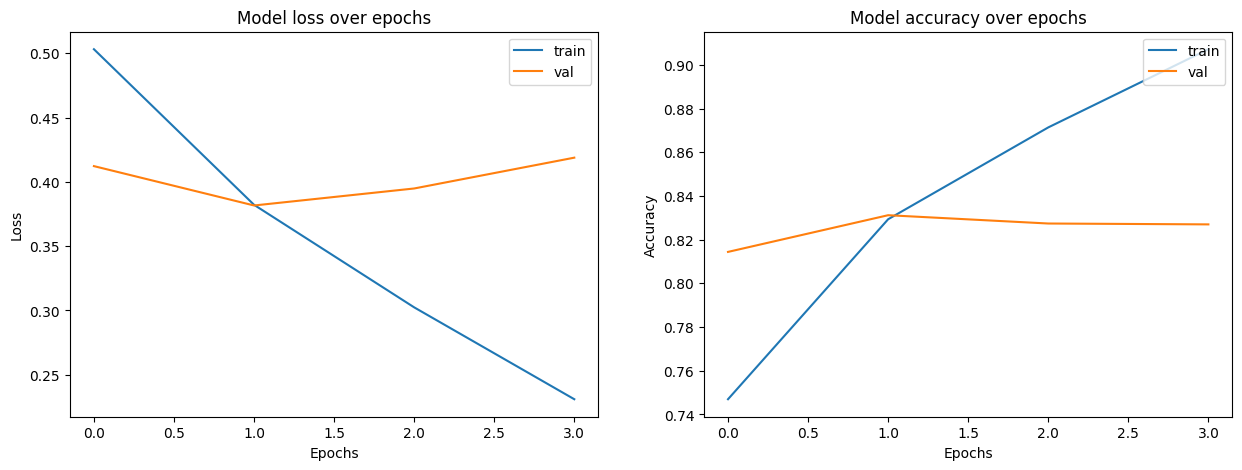

In [57]:
# Initialize the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot model loss during training
ax1.plot(history.history["loss"])
ax1.plot(history.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Model loss over epochs")

# Plot model accuracy during training
ax2.plot(history.history["accuracy"])
ax2.plot(history.history["val_accuracy"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Model accuracy over epochs")
plt.show()

# Predict some movie review samples

In [60]:
# Make prediction on new text reviews
sample_reviews = [('It is a cool movie. The graphics and the animation are awesome.'),
                  ('Shitty film')]
predictions = model.predict(np.array(sample_reviews))
print(predictions[0])
print(predictions[1])

1/1 [==============================] - 0s 42ms/step
[0.9996613]
[0.03891472]
